In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [ ]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## WARNING, FILE "delay_clean_SVM.txt" is > 1.2 GB  --  added to gitignore
## Using reduced dataset.....

In [ ]:
# Load and parse the data file, converting it to a DataFrame
clean = spark.read.format("libsvm").load('/content/drive/MyDrive/Colab_Notebooks/delay_clean_SVM.txt')
clean.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
clean.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Number of rows in dataset
number_rows = clean.count()
number_rows

6489024

In [ ]:
clean.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|5261657|
|  1.0|1227367|
+-----+-------+



In [ ]:
# Index labels, adding metadata to the label column
# Fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol = "label", outputCol = "indexedLabel").fit(clean)

In [ ]:
# Automatically identify categorical features, and index them
# Set maxCategories so features with > 4 distinct values are treated as continuous
featureIndexer = VectorIndexer(inputCol = "features", outputCol = "indexedFeatures", maxCategories = 4).fit(clean)

In [ ]:
from pyspark.ml.feature import Normalizer

In [ ]:
normalizer = Normalizer(inputCol = "features", outputCol = "normFeatures", p = 1.0)
NormOutput = normalizer.transform(clean)

In [ ]:
# Split the data into training and test sets
(trainingData, testData) = clean.randomSplit([0.7, 0.3])

In [ ]:
trainingData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
testData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



## Oversampling performed to dataset
### https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253

In [ ]:
from pyspark.sql.functions import col, explode, array, lit

In [ ]:
major_df = clean.filter(col("label") == 0)
minor_df = clean.filter(col("label") == 1)
ratio = int(major_df.count()/minor_df.count())
print("Ratio of original dataset: {}".format(ratio)+" to 1 (on time : delayed flights)")

Ratio of original dataset: 4 to 1 (on time : delayed flights)


In [ ]:
a = range(ratio)

In [ ]:
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

In [ ]:
# combine both oversampled minority rows and previous majority rows
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
combined_df.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|5261657|
|  1.0|4909468|
+-----+-------+



In [ ]:
# Split the data into training and test sets
(trainingData, testData) = combined_df.randomSplit([0.7, 0.3])

In [ ]:
trainingData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
testData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
|  0.0|(153,[0,1,2,3,4,5...|
+-----+--------------------+
only showing top 20 rows



# Gradient-boosted tree classifier (GBT)

In [ ]:
# Train a GBT model
gbt = GBTClassifier(labelCol = "indexedLabel", featuresCol = "indexedFeatures", maxIter = 30, maxDepth = 10,
                    stepSize = 1)

In [ ]:
# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages = [labelIndexer, featureIndexer, gbt])

In [ ]:
# Train model.  This also runs the indexers
model = pipeline.fit(trainingData)

In [ ]:
# Make predictions
predictions = model.transform(testData)

In [ ]:
# Select example rows to display
predictions.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       1.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
+----------+------------+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol = "indexedLabel", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.669598
Test Error = 0.330402


In [ ]:
gbtModel = model.stages[2]
print(gbtModel)  # summary only

GBTClassificationModel: uid = GBTClassifier_70a7ecc7e25f, numTrees=30, numClasses=2, numFeatures=153


In [ ]:
y_true = predictions.select(['indexedLabel']).collect()
y_pred = predictions.select(['prediction']).collect()

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1105620  472521]
 [ 536035  938340]]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.69   1578141
         1.0       0.67      0.64      0.65   1474375

    accuracy                           0.67   3052516
   macro avg       0.67      0.67      0.67   3052516
weighted avg       0.67      0.67      0.67   3052516



In [ ]:
importanceSummary = gbtModel.featureImportances
importanceSummary

SparseVector(153, {0: 0.0713, 1: 0.0494, 2: 0.0332, 3: 0.1016, 4: 0.0276, 5: 0.0405, 6: 0.0231, 7: 0.0358, 8: 0.0377, 9: 0.0233, 10: 0.0123, 11: 0.0083, 12: 0.0167, 13: 0.0331, 14: 0.0036, 15: 0.072, 16: 0.0084, 17: 0.0049, 18: 0.0693, 19: 0.0648, 20: 0.0086, 21: 0.0158, 22: 0.0118, 23: 0.0114, 24: 0.0123, 25: 0.0072, 26: 0.0074, 27: 0.0074, 28: 0.004, 29: 0.0028, 30: 0.0031, 31: 0.003, 32: 0.004, 33: 0.0043, 34: 0.0041, 35: 0.0046, 36: 0.0038, 37: 0.0067, 38: 0.0067, 39: 0.001, 40: 0.0003, 41: 0.0023, 42: 0.0004, 43: 0.0007, 44: 0.0009, 45: 0.0072, 46: 0.0017, 47: 0.0013, 48: 0.001, 49: 0.0057, 50: 0.0005, 51: 0.0027, 52: 0.0022, 53: 0.0004, 54: 0.0009, 55: 0.0009, 56: 0.0002, 57: 0.0001, 58: 0.0005, 59: 0.0001, 60: 0.0002, 61: 0.0004, 62: 0.0002, 63: 0.0003, 64: 0.0002, 65: 0.0002, 66: 0.001, 67: 0.002, 68: 0.0005, 69: 0.0004, 70: 0.0021, 71: 0.0004, 72: 0.0004, 73: 0.0012, 74: 0.0014, 75: 0.0002, 76: 0.0003, 77: 0.0013, 78: 0.0005, 79: 0.0003, 80: 0.0002, 81: 0.0002, 82: 0.0006, 83:

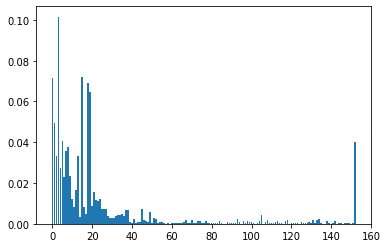

In [ ]:
from matplotlib import pyplot as plt
plt. bar(x = range (len (importanceSummary)), height = importanceSummary)
plt.show()

In [ ]:
model_path = "./hdfsData/" + "GBTmodel"
model.write().overwrite().save(model_path)

# Random forest classifier (RFC)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString

In [ ]:
# Train a RandomForest model
rf = RandomForestClassifier(labelCol = "indexedLabel", featuresCol = "indexedFeatures", numTrees = 40)

In [ ]:
# Convert indexed labels back to original labels
labelConverter = IndexToString(inputCol = "prediction", outputCol = "predictedLabel",
                               labels = labelIndexer.labels)

In [ ]:
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages = [labelIndexer, featureIndexer, rf, labelConverter])

In [ ]:
# Train model.  This also runs the indexers
model = pipeline.fit(trainingData)

In [ ]:
# Make predictions
predictions1 = model.transform(testData)

In [ ]:
# Select example rows to display
predictions1.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(153,[0,1,2,3,4,5...|
|           1.0|  0.0|(153,[0,1,2,3,4,5...|
|           1.0|  0.0|(153,[0,1,2,3,4,5...|
|           0.0|  0.0|(153,[0,1,2,3,4,5...|
|           0.0|  0.0|(153,[0,1,2,3,4,5...|
+--------------+-----+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol = "indexedLabel", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions1)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.603692
Test Error = 0.396308


In [ ]:
rfModel = model.stages[2]
print(rfModel)  # summary only

RandomForestClassificationModel: uid=RandomForestClassifier_c8f74eafa30b, numTrees=40, numClasses=2, numFeatures=153


In [ ]:
print(rfModel.featureImportances)

(153,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,42,45,47,48,49,51,52,53,54,55,59,60,63,64,66,67,70,73,74,76,77,83,84,86,89,90,93,96,98,100,103,105,108,112,113,118,121,130,131,134,135,138,142,144,151,152],[0.031050717156749154,0.00010319826869544478,0.00243538058121901,0.2388306227854665,0.004100228869956541,0.0025544941337272468,0.012932233779901992,0.016792981782426615,0.002884594250020264,0.014051040104386268,0.0065123619865341004,0.0037849231384734275,0.0032489092721131522,0.0004343868942953729,0.08985809447108004,0.12153576253242773,0.027683100207845073,0.002179586283937726,0.002517512557652849,0.013155636047284596,0.035400165155278454,0.08112673003061684,0.06138704704257133,0.06644461681521747,0.012358509350457542,0.0035449871174032337,0.0022895144005150676,0.0004208006203170107,0.00027950527493122377,0.0009009639009639897,0.0003406622164390271,0.0007950608958960094,0.01234733466934345,0.022306454426369457,0.01781

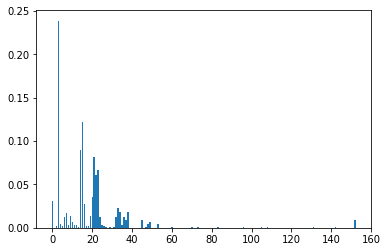

In [ ]:
from matplotlib import pyplot as plt
plt. bar(x = range (len (rfModel.featureImportances)), height = rfModel.featureImportances)
plt.show()

In [ ]:
y_true = predictions1.select(['indexedLabel']).collect()
y_pred = predictions1.select(['prediction']).collect()

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[942803 635338]
 [574397 899978]]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61   1578141
         1.0       0.59      0.61      0.60   1474375

    accuracy                           0.60   3052516
   macro avg       0.60      0.60      0.60   3052516
weighted avg       0.60      0.60      0.60   3052516



In [ ]:
model_path = "./hdfsData/" + "RFmodel"
model.write().overwrite().save(model_path)

# Factorization machines classifier

In [ ]:
from pyspark.ml.classification import FMClassifier
from pyspark.ml.feature import MinMaxScaler

In [ ]:
# Index labels, adding metadata to the label column
# Fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol = "label", outputCol = "indexedLabel").fit(clean)

# Scale features
featureScaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures").fit(clean) 

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = clean.randomSplit([0.7, 0.3])

In [ ]:
# Train a FM model
fm = FMClassifier(labelCol = "indexedLabel", featuresCol = "scaledFeatures", stepSize = 0.01)

In [ ]:
# Create a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureScaler, fm])

In [ ]:
# Train model
model = pipeline.fit(trainingData)

In [ ]:
# Make predictions
predictions2 = model.transform(testData)

In [ ]:
# Select example rows to display
predictions2.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
|       0.0|         0.0|(153,[0,1,2,3,4,5...|
+----------+------------+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol = "indexedLabel", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions2)
print("Test set accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Test set accuracy = 0.812094
Test Error = 0.187906


In [ ]:
y_true = predictions2.select(['indexedLabel']).collect()
y_pred = predictions2.select(['prediction']).collect()

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1573967    3830]
 [ 361767    6077]]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90   1577797
         1.0       0.61      0.02      0.03    367844

    accuracy                           0.81   1945641
   macro avg       0.71      0.51      0.46   1945641
weighted avg       0.78      0.81      0.73   1945641



In [ ]:
model_path = "./hdfsData/" + "FMmodel"
model.write().overwrite().save(model_path)